# Creating Local RAG Pipeline from Scratch

## 1. Data Preparation

### 1.1 Importing PDF Document for our Book

In [1]:
import os
import re
import fitz
import random
import requests
import textwrap
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import List, Dict  # for type hints
from spacy.lang.en import English
from transformers.utils import is_flash_attn_2_available
from sentence_transformers import util, SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
import torch

In [3]:
# getting pdf documents from local system
pdf_path = "/Users/adityamishra/Documents/Machine Learning Tutorial/4. RAG/clrs.pdf"

# download pdf if not present
if not os.path.exists(pdf_path):
    print(f"Given path {pdf_path} does not exist. Downloading the pdf file!!!")
    url = "https://www.cs.mcgill.ca/~akroit/math/compsci/Cormen%20Introduction%20to%20Algorithms.pdf"
    
    filename = pdf_path
    response = requests.get(url)# download the file
    
    if response.status_code == 200: # check if the download was successful
        with open(filename, 'wb') as file:
            file.write(response.content)# save the file
        print(f"File downloaded and saved as {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
else:
    print(f"File already exists at {pdf_path}. Proceeding to read the file.")

File already exists at /Users/adityamishra/Documents/Machine Learning Tutorial/4. RAG/clrs.pdf. Proceeding to read the file.


Sine now we have imported our file now next step is to preprocess the text as we read it. We have imported the pages of book in the `file_path` and now we can open and read it with `PyMuPDF` by typing command `import fitz`.

In [4]:
def text_formatter(text: str) -> str:
    #fixing hyphenated words split across lines
    text = re.sub(r'(\w+)-\s*\n\s*(\w+)', r'\1\2', text)
    # fixing words split across lines WITHOUT hyphens
    text = re.sub(r'(\w+)\s*\n\s*(\w+)', lambda m: m.group(1) + m.group(2) if m.group(2)[0].islower() else m.group(0), text)
    # preserve code blocks
    lines = text.split('\n')
    processed_lines = []
    in_code_block = False

    for i, line in enumerate(lines):
        stripped = line.strip()
        #skipping empty lines
        if not stripped:
            processed_lines.append('')
            continue

        # checking if code or pseudocode
        is_code_line = (
            len(line) - len(line.lstrip()) >= 4 or  # 4+ space indent
            stripped.startswith('//') or  # comment
            re.match(r'^(if|for|while|return|else)\b', stripped, re.IGNORECASE) or
            re.match(r'^[A-Z][A-Z\-]+\(', stripped)  # FUNCTION-NAME(
        )

        if is_code_line:
            in_code_block = True
            # keeping the line with a marker
            processed_lines.append('__CODELINE__' + line)
        else:
            # checking if we just exited a code block
            if in_code_block:
                processed_lines.append('__CODEEND__')
                in_code_block = False
            processed_lines.append(line)

    text = '\n'.join(processed_lines)

    #paragraph joining for non-code text where we join lines that are part of the same paragraph
    text = re.sub(
        r'(?<!__CODELINE__)(?<!__CODEEND__)(?<!\n)\n(?!__CODELINE__)(?!__CODEEND__)(?!\n)(?![A-Z])', ' ', text)
    #cleaning up markers
    text = text.replace('__CODELINE__', '')
    text = text.replace('__CODEEND__', '\n')
    #removing excessive blank lines (3+) but keep double newlines for sections
    text = re.sub(r'\n{3,}', '\n\n', text)
    #cleaning up multiple spaces (but not at line start - that's indentation)
    text = re.sub(r'([^\n]) {2,}', r'\1 ', text)
    #fixing spacing around punctuation
    text = re.sub(r'\s+([.,;:!?])', r'\1', text)
    #removing standalone page numbers (just digits on their own line)
    text = re.sub(r'^\s*\d{1,4}\s*$', '', text, flags=re.MULTILINE)
    #removing common header and footer patterns
    text = re.sub(r'^(Chapter|Section)\s+\d+.*$', '',
                  text, flags=re.MULTILINE | re.IGNORECASE)
    text = text.strip()
    return text

#detecting block of algorithm in clrs
def is_algorithm_block(text: str) -> bool:
    indicators = [
        bool(re.search(r'\b(if|then|else)\b', text, re.IGNORECASE)),
        bool(re.search(r'\b(for|while|do)\b', text, re.IGNORECASE)),
        bool(re.search(r'\breturn\b', text, re.IGNORECASE)),
        bool(re.search(r'^\s*//.*', text, re.MULTILINE)),  # comments
        bool(re.search(r'[A-Z][A-Z\-]+\([^)]*\)', text)),  # FUNCTION(...)
        bool(re.search(r'A\[\s*\d+', text)),  # Array notation A[1]
        bool(re.search(r'←|:=|=', text)),  # Assignment operators
    ]
    # Need at least 2 indicators and text should be substantial
    return sum(indicators) >= 2 and len(text.split()) > 10

#section header text
def is_section_header(text: str) -> bool:
    text = text.strip()
    if not text or len(text) > 100:
        return False

    words = text.split()
    if len(words) > 15 or len(words) < 2:
        return False
    # Skip table of contents entries (have lots of dots)
    if text.count('.') > 3:
        return False
    # Skip if it's just "Contents" or roman numerals
    if text.lower() in ['contents', 'preface', 'index', 'references']:
        return False
    # Likely a header if it doesn't end with period and isn't too long
    return not text.endswith('.')

#detecting table of contents
def is_toc_or_front_matter(text: str) -> bool:
    indicators = [
        'contents' in text.lower()[:50],
        'preface' in text.lower()[:50],
        text.count('...') > 2,  # TOC dots
        # Too many periods (TOC page numbers)
        text.count('.') > len(text.split()) * 0.5,
        # Roman numerals only
        bool(re.search(r'^[ivxlcdm]+$', text.strip(), re.IGNORECASE)),
    ]
    return any(indicators) or len(text.split()) < 5

#preserving chunk for contexts
def smart_chunker(pages_and_texts: List[Dict],
                  chunk_size: int = 1000,
                  overlap: int = 200,
                  skip_front_matter: bool = True) -> List[Dict]:
    chunks = []

    for page_data in pages_and_texts:
        text = page_data['text']
        page_num = page_data['page_number']

        # Skip if this looks like front matter
        if skip_front_matter and is_toc_or_front_matter(text):
            continue
        # Skip very short pages (likely artifacts)
        if len(text.split()) < 10:
            continue
        # Split by double newlines to get paragraphs/blocks
        blocks = re.split(r'\n\n+', text)

        current_chunk = ""
        current_chunk_metadata = {
            'page_number': page_num,
            'has_algorithm': False,
            'section_header': None
        }
        for block in blocks:
            block = block.strip()
            if not block or len(block) < 10:
                continue
            if is_section_header(block):# if we have a current chunk, save it
                if current_chunk and len(current_chunk.split()) > 10:
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                # Start new chunk with this header
                current_chunk = block + "\n\n"
                current_chunk_metadata = {
                    'page_number': page_num,
                    'has_algorithm': False,
                    'section_header': block
                }
                continue

            # Check if this is an algorithm block
            block_has_algo = is_algorithm_block(block)
            if block_has_algo:
                current_chunk_metadata['has_algorithm'] = True

                # If adding this would exceed chunk_size significantly and we have content, save current chunk
                if len(current_chunk) + len(block) > chunk_size * 1.5 and len(current_chunk.split()) > 20:
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                    # Start new chunk with overlap from previous
                    if len(current_chunk) > overlap:
                        # Get more than we need to find clean word boundary
                        overlap_start = max(
                            0, len(current_chunk) - overlap - 50)
                        overlap_text = current_chunk[overlap_start:]
                        # Find first complete word (space followed by word followed by space)
                        match = re.search(r'\s+(\S+\s+)', overlap_text)
                        if match:
                            # Start from the beginning of that complete word
                            overlap_text = overlap_text[match.start(1):]
                        else:
                            # Fallback: just find first space
                            space_idx = overlap_text.find(' ')
                            if space_idx > 0:
                                overlap_text = overlap_text[space_idx+1:]
                    else:
                        overlap_text = current_chunk
                    current_chunk = overlap_text + "\n\n" + block + "\n\n"
                    current_chunk_metadata = {
                        'page_number': page_num,
                        'has_algorithm': True,
                        'section_header': current_chunk_metadata['section_header']
                    }
                else:
                    # Add algorithm block to current chunk (keep it together!)
                    current_chunk += block + "\n\n"
            else:
                # Regular text block
                if len(current_chunk) + len(block) > chunk_size and len(current_chunk.split()) > 20:
                    # Save current chunk
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                    # Start new chunk with overlap
                    if len(current_chunk) > overlap:
                        # Find word boundary for clean overlap
                        overlap_text = current_chunk[-overlap:]
                        # Adjust to start at word boundary
                        space_idx = overlap_text.find(' ')
                        if space_idx > 0:
                            overlap_text = overlap_text[space_idx+1:]
                    else:
                        overlap_text = current_chunk
                    current_chunk = overlap_text + "\n\n" + block + "\n\n"
                    current_chunk_metadata = {
                        'page_number': page_num,
                        'has_algorithm': False,
                        'section_header': current_chunk_metadata['section_header']
                    }
                else:
                    current_chunk += block + "\n\n"

        # Save the last chunk from this page if it's substantial
        if current_chunk.strip() and len(current_chunk.split()) > 10:
            chunks.append({
                'text': current_chunk.strip(),
                'page_number': current_chunk_metadata['page_number'],
                'chunk_char_count': len(current_chunk),
                'chunk_word_count': len(current_chunk.split()),
                'chunk_token_count': len(current_chunk) / 4,
                'has_algorithm': current_chunk_metadata['has_algorithm'],
                'section_header': current_chunk_metadata['section_header']
            })

    # Add chunk IDs
    for i, chunk in enumerate(chunks):
        chunk['chunk_id'] = i

    return chunks

In [5]:
def open_and_read_pdf(pdf_path: str, page_offset: int = 0) -> List[Dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc), desc="Reading PDF pages", total=len(doc)):
        text = page.get_text()
        text = text_formatter(text)
        # Skip completely empty pages
        if not text.strip():
            continue
        pages_and_texts.append({
            "page_number": page_number - page_offset,
            "pdf_page_number": page_number,  # Keep original for reference
            "page_char_count": len(text),
            "page_word_count": len(text.split()),
            "page_sentence_count_raw": len(text.split(". ")),
            "page_token_count": len(text) / 4,
            "text": text
        })

    return pages_and_texts

def find_content_start_page(pdf_path: str, sample_size: int = 50) -> int:
    doc = fitz.open(pdf_path)
    for page_num in range(min(sample_size, len(doc))):
        page = doc[page_num]
        text = page.get_text()

        #looking for indicators of actual content like chapter 1 and introduction etc.
        if re.search(r'chapter\s+1|^1\s+introduction', text, re.IGNORECASE | re.MULTILINE):
            print(f"Found likely content start at PDF page {page_num}")
            print(f"First 200 chars: {text[:200]}")
            return page_num

    print("Could not automatically find content start. Please check manually.")
    return 0

In [6]:
content_start = find_content_start_page(pdf_path)
pages_and_texts = open_and_read_pdf(pdf_path, page_offset=41)
chunks = smart_chunker(pages_and_texts, chunk_size=1000,
                       overlap=200, skip_front_matter=True)
print(f"Total pages: {len(pages_and_texts)}")
print(f"Total chunks: {len(chunks)}")
print(
    f"Chunks with algorithms: {sum(1 for c in chunks if c['has_algorithm'])}")
for i in range(50, 53):
    print(f"\n{'='*60}")
    print(f"Chunk {i}:")
    print(
        f"Page: {chunks[i]['page_number']}, Has algo: {chunks[i]['has_algorithm']}")
    print(f"Header: {chunks[i]['section_header']}")
    print(f"Text preview: {chunks[i]['text'][:300]}...")

Found likely content start at PDF page 23
First 200 chars: Introduction
This part will start you thinking about designing and analyzing algorithms. It is
intended to be a gentle introduction to how we specify algorithms, some of the
design strategies we will 


Reading PDF pages:   0%|          | 0/1313 [00:00<?, ?it/s]

Total pages: 1306
Total chunks: 1931
Chunks with algorithms: 1260

Chunk 50:
Page: 14, Has algo: True
Header: None
Text preview: 2.3
Designing algorithms 35 5 2 4 7 1 3 2 6 2 5 4 7 1 3 2 6 2 4 5 7 1 2 3 6 1 2 2 3 4 5 6 7 mergemerge mergesorted sequenceinitial sequencemerge mergemerge merge
Figure 2.4
The operation of merge sort on the array A D h5; 2; 4; 7; 1; 3; 2; 6i. The lengths of thesorted sequences being merged increase...

Chunk 51:
Page: 15, Has algo: True
Header: None
Text preview: Getting Startedthe original problem size is a power of 2. Each divide step then yields two subsequences of size exactly n=2. In Chapter 4, we shall see that this assumption doesnot affect the order of growth of the solution to the recurrence.
We reason as follows to set up the recurrence for T.n/, t...

Chunk 52:
Page: 15, Has algo: True
Header: 2T.n=2/ C ‚.n/
if n > 1:
Text preview: 2T.n=2/ C ‚.n/
if n > 1:

(2.1)
In Chapter 4, we shall see the “master theorem,” which we can use to showthat T.n/ is

In [7]:
random.sample(pages_and_texts, k=3)# finding random text from random pages

[{'page_number': 768,
  'pdf_page_number': 809,
  'page_char_count': 2322,
  'page_word_count': 409,
  'page_sentence_count_raw': 17,
  'page_token_count': 580.5,
  'text': '27.1\nThe basics of dynamic multithreading 789 incr r1 3 r1 = x 2 x = r1 7 incr r2 5 r2 = x 4 x = r2 6 x = 0 1 print x 8 (a) stepx r1r2 1 2 3 4 5 6 7 0 0 0 0 0 1 1 – 0 1 1 1 1 1 – – – 0 1 1 1 (b)\nFigure 27.5\nIllustration of the determinacy race in RACE-EXAMPLE. (a) A computation dag showing the dependencies among individual instructions. The processor registers are r1 and r2. Instructions unrelated to the race, such as the implementation of loop control, are omitted. (b) An executionsequence that elicits the bug, showing the values of x in memory and registers r1 and r2 for eachstep in the execution sequence. printed. Conversely, if the effect were that processor 2 executed all its instructionsbefore processor 1, the value 2 would still be printed. When the instructions of thetwo processors execute at the same ti

### 1.2 Getting Text Statistics


In [8]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,0,189,92,4,47.25,A L G O R I T H M S\nI N T R O D U C T I O N T...
1,-40,1,40,5,1,10.00,Introduction to Algorithms\nThird Edition
2,-38,3,165,23,4,41.25,Thomas H. Cormen\nCharles E. Leiserson\nRonald...
3,-37,4,883,127,13,220.75,c 2009 Massachusetts Institute of Technology\n...
4,-36,5,876,134,1,219.00,Contents\nPreface xiii\nI\nFoundations\nIntrod...


In [9]:
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59
std,378.27,378.27,562.75,94.74,9.72,140.69
min,-41.00,0.00,13.00,2.00,1.00,3.25
25%,288.25,329.25,1547.25,279.00,9.00,386.81
50%,615.50,656.50,1918.00,339.00,12.00,479.50
75%,942.75,983.75,2282.25,396.00,15.00,570.56
max,1271.00,1312.00,3225.00,570.00,103.00,806.25


### 1.3 Splitting Pages into Sentences

In [10]:
nlp = English()
nlp.add_pipe("sentencizer")
# making a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2
#Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [11]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)# extracting sentences using spacy
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]# Make sure all sentences are strings      
    # counting the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1306 [00:00<?, ?it/s]

In [12]:
random.sample(pages_and_texts, k=1)

[{'page_number': -32,
  'pdf_page_number': 9,
  'page_char_count': 1200,
  'page_word_count': 169,
  'page_sentence_count_raw': 1,
  'page_token_count': 300.0,
  'text': 'Contentsix 24\nSingle-Source Shortest Paths 643 24.1 The Bellman-Ford algorithm 651 24.2 Single-source shortest paths in directed acyclic graphs 655 24.3 Dijkstra’s algorithm 658 24.4 Difference constraints and shortest paths 664 24.5 Proofs of shortest-paths properties 671 25\nAll-Pairs Shortest Paths 684 25.1 Shortest paths and matrix multiplication 686 25.2 The Floyd-Warshall algorithm 693 25.3 Johnson’s algorithm for sparse graphs 700 26\nMaximum Flow 708 26.1 Flow networks 709 26.2 The Ford-Fulkerson method 714 26.3 Maximum bipartite matching 732? 26.4 Push-relabel algorithms 736? 26.5 The relabel-to-front algorithm 748\nVII\nSelected Topics\nIntroduction 769 27\nMultithreaded Algorithms 772 27.1 The basics of dynamic multithreading 774 27.2 Multithreaded matrix multiplication 792 27.3 Multithreaded merge sort 79

In [13]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59,14.41
std,378.27,378.27,562.75,94.74,9.72,140.69,7.97
min,-41.00,0.00,13.00,2.00,1.00,3.25,1.00
25%,288.25,329.25,1547.25,279.00,9.00,386.81,10.00
50%,615.50,656.50,1918.00,339.00,12.00,479.50,14.00
75%,942.75,983.75,2282.25,396.00,15.00,570.56,17.00
max,1271.00,1312.00,3225.00,570.00,103.00,806.25,68.00


### 1.4 Splitting Sentences

The purpose of splitting our texts into smaller groups is that we want them to fit into our embedding model context window which is having 384 tokens limit.

In [14]:
num_sentence_chunk_size = 10# setting chunk size for sentences
print(f"Sentence chunk size set to: {num_sentence_chunk_size}")

#creating function to split text into sentence chunks
def split_list(input_list: list[str], slice_size:int = num_sentence_chunk_size) -> list[list[str]]:    
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

Sentence chunk size set to: 10


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [15]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1306 [00:00<?, ?it/s]

In [16]:
random.sample(pages_and_texts, k=1)# getting random sample of sentence chunks

[{'page_number': 285,
  'pdf_page_number': 326,
  'page_char_count': 1198,
  'page_word_count': 229,
  'page_sentence_count_raw': 10,
  'page_token_count': 299.5,
  'text': 'Binary Search Trees\nAt each recursive invocation of quicksort, we choose a random pivot element topartition the set of elements being sorted. Each node of a binary search tree partitions the set of elements that fall into the subtree rooted at that node. f.\nDescribe an implementation of quicksort in which the comparisons to sort a setof elements are exactly the same as the comparisons to insert the elements intoa binary search tree. (The order in which comparisons are made may differ, butthe same comparisons must occur.) 12-4\nNumber of different binary trees\nLet bn denote the number of different binary trees with n nodes. In this problem, you will ﬁnd a formula for bn, as well as an asymptotic estimate. a. Show that b0 D 1 and that, for n \x15 1, bn Dn\x001\nX kD0bkbn\x001\x00k: b. Referring to Problem 4-4 for 

In [17]:
df = pd.DataFrame(pages_and_texts)# creating dataframe
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59,14.41,1.89
std,378.27,378.27,562.75,94.74,9.72,140.69,7.97,0.83
min,-41.00,0.00,13.00,2.00,1.00,3.25,1.00,1.00
25%,288.25,329.25,1547.25,279.00,9.00,386.81,10.00,1.00
50%,615.50,656.50,1918.00,339.00,12.00,479.50,14.00,2.00
75%,942.75,983.75,2282.25,396.00,15.00,570.56,17.00,2.00
max,1271.00,1312.00,3225.00,570.00,103.00,806.25,68.00,7.00


### 1.5 Splitting Each Partition into an Item

In [18]:
pages_and_chunks = []# list to hold page and chunk information
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}# dictionary to hold chunk information
        chunk_dict["page_number"] = item["page_number"]# page number

        joined_sentence_chunk = "".join(
            sentence_chunk).replace("  ", " ").strip()# Join the sentences together into a paragraph-like structure as  chunk (so they are a single string)
        # ".A" -> ". A" for any full-stop/capital letter combo
        joined_sentence_chunk = re.sub(
            r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len(
            [word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(
            joined_sentence_chunk) / 4  # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1306 [00:00<?, ?it/s]

2472

In [19]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 483,
  'sentence_chunk': 'B-Treeshow to implement these operations on 2-3-4 trees. We assume for convenience thatelements consist only of keys and that all key values are distinct.a. Show how to maintain, for every node x of a 2-3-4 tree, the height of the subtreerooted at x as an attribute x:height. Make sure that your implementation doesnot affect the asymptotic running times of searching, insertion, and deletion.b. Show how to implement the join operation. Given two 2-3-4 trees T 0 and T 00and a key k, the join operation should run in O.1 C jh0 \x00 h00j/ time, where h0and h00 are the heights of T 0 and T 00, respectively.c. Consider the simple path p from the root of a 2-3-4 tree T to a given key k, the set S 0 of keys in T that are less than k, and the set S 00 of keys in T that aregreater than k. Show that p breaks S 0 into a set of trees fT 0 0; T 0 1;:::; T 0mg and aset of keys fk0 1; k0 2;:::; k0mg, where, for i D 1; 2;:::; m, we have y < k0i < ´\nfor any keys

In [20]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2472.00,2472.00,2472.00,2472.00
mean,649.99,995.77,169.32,248.94
std,391.42,511.97,94.10,127.99
min,-41.00,4.00,1.00,1.00
25%,317.75,569.50,86.00,142.38
50%,648.50,1033.00,172.00,258.25
75%,1001.25,1361.00,235.00,340.25
max,1271.00,2559.00,491.00,639.75


In [21]:
chunks_over_512 = df[df['chunk_token_count'] > 512].shape[0]
percentage = (chunks_over_512 / 2472) * 100

In [22]:
print(f"Number of chunks over 512 tokens: {chunks_over_512} ({percentage:.2f}%)")

Number of chunks over 512 tokens: 45 (1.82%)


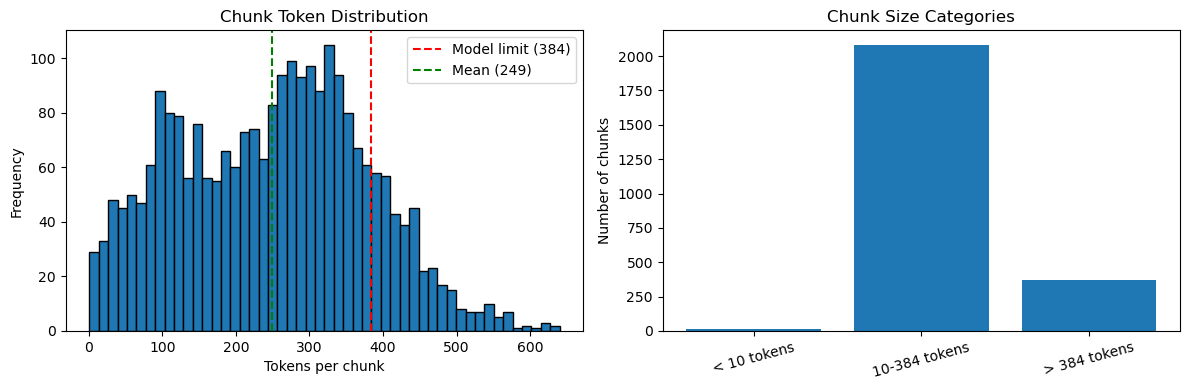


Chunk Analysis:
  Total chunks: 2472
  Too small (< 10 tokens): 17 (0.7%)
  Perfect size (10-384): 2083 (84.3%)
  Too large (> 384): 372 (15.0%)


In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Token count distribution
plt.subplot(1, 2, 1)
plt.hist(df['chunk_token_count'], bins=50, edgecolor='black')
plt.axvline(x=384, color='red', linestyle='--', label='Model limit (384)')
plt.axvline(x=df['chunk_token_count'].mean(), color='green',
            linestyle='--', label=f'Mean ({df["chunk_token_count"].mean():.0f})')
plt.xlabel('Tokens per chunk')
plt.ylabel('Frequency')
plt.title('Chunk Token Distribution')
plt.legend()

# Check problematic chunks
plt.subplot(1, 2, 2)
sizes = ['< 10 tokens', '10-384 tokens', '> 384 tokens']
counts = [
    len(df[df['chunk_token_count'] < 10]),
    len(df[(df['chunk_token_count'] >= 10) & (df['chunk_token_count'] <= 384)]),
    len(df[df['chunk_token_count'] > 384])
]
plt.bar(sizes, counts)
plt.ylabel('Number of chunks')
plt.title('Chunk Size Categories')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

print(f"\nChunk Analysis:")
print(f"  Total chunks: {len(df)}")
print(f"  Too small (< 10 tokens): {counts[0]} ({counts[0]/len(df)*100:.1f}%)")
print(f"  Perfect size (10-384): {counts[1]} ({counts[1]/len(df)*100:.1f}%)")
print(f"  Too large (> 384): {counts[2]} ({counts[2]/len(df)*100:.1f}%)")

In [24]:
print(f"Using all {len(chunks)} chunks")
print("Model will auto-truncate 372 large chunks")

Using all 1931 chunks
Model will auto-truncate 372 large chunks


In [25]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,A L G O R I T H M S\nI N T R O D U C T I O N T...,189,85,47.25
1,-40,Introduction to Algorithms\nThird Edition,40,4,10.00
2,-38,Thomas H. Cormen\nCharles E. Leiserson\nRonald...,165,15,41.25
3,-37,c 2009 Massachusetts Institute of Technology\n...,742,93,185.50
4,-37,alk.paper) 1. Computer programming.2. Computer...,137,22,34.25


In [26]:
min_token_length = 15# setting minimum token length
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():# iterating through rows with chunk token count less than or equal to minimum token length
    print(
        f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 2.25 | Text: Show that
Chunk token count: 4.0 | Text: As a result, for
Chunk token count: 13.0 | Text: This additional test explicitly checks the condition
Chunk token count: 10.5 | Text: IV
Advanced Design and Analysis Techniques
Chunk token count: 14.75 | Text: Perform the inverse of the permutation performed in step 2.


In [27]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -41,
  'sentence_chunk': 'A L G O R I T H M S\nI N T R O D U C T I O N T O\nT H I R D E D I T I O N\nT H O M A S H. \nC H A R L E S E. \nR O N A L D L. \nC L I F F O R D\nS T E I N\nR I V E S T\nL E I S E R S O N\nC O R M E N',
  'chunk_char_count': 189,
  'chunk_word_count': 85,
  'chunk_token_count': 47.25},
 {'page_number': -38,
  'sentence_chunk': 'Thomas H. Cormen\nCharles E. Leiserson\nRonald L. Rivest\nClifford Stein\nIntroduction to Algorithms\nThird Edition\nThe MIT Press\nCambridge, Massachusetts\nLondon, England',
  'chunk_char_count': 165,
  'chunk_word_count': 15,
  'chunk_token_count': 41.25}]

In [28]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 1203,
  'sentence_chunk': 'Theorem D.4 (Determinant properties)\nThe determinant of a square matrix A has the following properties: \x0f\nIf any row or any column of A is zero, then det. A/ D 0.\n\n\x0f\nThe determinant of A is multiplied by \x15 if the entries of any one row (or anyone column) of A are all multiplied by \x15. \x0f\nThe determinant of A is unchanged if the entries in one row (respectively, column) are added to those in another row (respectively, column).\x0f\nThe determinant of A equals the determinant of AT.\x0f\nThe determinant of A is multiplied by \x001 if any two rows (or any two columns) are exchanged.\nAlso, for any square matrices A and B, we have det. AB/ D det. A/ det. B/.',
  'chunk_char_count': 648,
  'chunk_word_count': 117,
  'chunk_token_count': 162.0}]

## 2. Creating Embeddings

In [29]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")
sentences = [
    "If the array is already sorted in decreasing order, then, the pivot element is less than all the other elements.",
    "A return statement immediately transfers control back to the point of call in the calling procedure.",
    "The keyword error indicates that an error occurred because conditions were wrong for the procedure to have been called",
    "The time taken by the INSERTION-SORT procedure depends on the input"
]
embeddings = embedding_model.encode(sentences)# creating embeddings for the sentences
embeddings_dict = dict(zip(sentences, embeddings))# creating a dictionary of sentences and their embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: If the array is already sorted in decreasing order, then, the pivot element is less than all the other elements.
Embedding: [-7.57872090e-02 -1.22801721e-01 -9.92374308e-03  3.83852609e-02
  1.09934630e-02 -2.47955788e-02 -2.62985118e-02 -3.41289863e-02
  1.38155036e-02  5.26514947e-02  4.05466929e-02  6.77561387e-02
  5.65900691e-02  2.12849975e-02  8.45210347e-03  2.87772366e-03
  8.74242652e-03 -6.80725137e-03  3.81463915e-02  4.65781949e-02
 -2.48106793e-02 -2.30073016e-02 -4.36398275e-02  7.21029146e-03
  7.42234662e-02  1.12223206e-02  4.17781156e-03  4.55432124e-02
  3.59460711e-02  1.36189936e-02 -4.39491272e-02  2.93691400e-02
 -1.42447148e-02 -7.34402984e-02  1.43368334e-06 -2.11693011e-02
  6.15315046e-03 -1.27934376e-02  5.23717627e-02 -1.58440247e-02
  5.28002996e-03 -3.50435786e-02 -4.20865826e-02 -9.55968723e-03
  3.84483999e-03 -4.66263480e-02 -2.23880392e-02  4.07274924e-02
  3.36727463e-02 -2.13507004e-02  2.27863807e-03 -1.48713225e-02
  8.37338045e-02 -2.0

In [30]:
embeddings[0].shape

(768,)

In [31]:
import torch
print(torch.backends.mps.is_available())

True


In [32]:
%%time
embedding_model.to("mps")  # Use GPU via Apple's Metal backend
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(
        item["sentence_chunk"]
    )  # creating embeddings for the sentence chunks


  0%|          | 0/2438 [00:00<?, ?it/s]

CPU times: user 3min 24s, sys: 25.6 s, total: 3min 49s
Wall time: 5min 48s


In [33]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len] # extracting sentence chunks

In [34]:
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32,  convert_to_tensor=True)
text_chunk_embeddings

tensor([[-0.0655, -0.0349, -0.0133,  ...,  0.0538, -0.0036,  0.0226],
        [-0.0205, -0.0198, -0.0266,  ..., -0.0105,  0.0293,  0.0002],
        [-0.0267,  0.0273, -0.0267,  ...,  0.0045, -0.0064, -0.0122],
        ...,
        [-0.0291, -0.0511, -0.0353,  ..., -0.0154, -0.0059, -0.0303],
        [-0.0451, -0.0541, -0.0558,  ..., -0.0193, -0.0117, -0.0444],
        [-0.0024,  0.0425, -0.0220,  ...,  0.0353, -0.0073, -0.0338]],
       device='mps:0')

In [35]:
#saving embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [36]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)# loading the saved embeddings from file
text_chunks_and_embedding_df_load.head()# displaying the head of the loaded dataframe

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,A L G O R I T H M S\nI N T R O D U C T I O N T...,189,85,47.25,[-6.54905811e-02 -3.49067412e-02 -1.33199077e-...
1,-38,Thomas H. Cormen\nCharles E. Leiserson\nRonald...,165,15,41.25,[-2.05252115e-02 -1.97694134e-02 -2.66364962e-...
2,-37,c 2009 Massachusetts Institute of Technology\n...,742,93,185.50,[-2.66846120e-02 2.72524450e-02 -2.67211795e-...
3,-37,alk.paper) 1. Computer programming.2. Computer...,137,22,34.25,[-2.02264674e-02 -3.64451446e-02 -3.75404581e-...
4,-36,Contents\nPreface xiii\nI\nFoundations\nIntrod...,874,106,218.50,[ 3.65013815e-02 2.32193316e-03 -9.05453600e-...


## 2. Implementing RAG

### 2.1 Building Similarity Search

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# importing the saved embeddings from file
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))# converting string representation of embeddings back to numpy arrays
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")# creating a list of dictionaries from the dataframe
#converting embeddings to torch tensor
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape


torch.Size([2438, 768])

In [38]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,A L G O R I T H M S\nI N T R O D U C T I O N T...,189,85,47.25,"[-0.0654905811, -0.0349067412, -0.0133199077, ..."
1,-38,Thomas H. Cormen\nCharles E. Leiserson\nRonald...,165,15,41.25,"[-0.0205252115, -0.0197694134, -0.0266364962, ..."
2,-37,c 2009 Massachusetts Institute of Technology\n...,742,93,185.50,"[-0.026684612, 0.027252445, -0.0267211795, 0.0..."
3,-37,alk.paper) 1. Computer programming.2. Computer...,137,22,34.25,"[-0.0202264674, -0.0364451446, -0.0375404581, ..."
4,-36,Contents\nPreface xiii\nI\nFoundations\nIntrod...,874,106,218.50,"[0.0365013815, 0.00232193316, -0.009054536, 0...."


In [39]:
embeddings[0]

tensor([-6.5491e-02, -3.4907e-02, -1.3320e-02, -3.0557e-02, -7.1670e-03,
        -3.6069e-03,  5.3057e-02,  1.0428e-03, -6.4981e-03,  8.5996e-02,
         2.3541e-02,  3.5456e-02,  1.9934e-02,  2.9792e-03,  2.5451e-02,
        -8.5283e-03,  3.1516e-02,  2.1661e-02, -1.5421e-02, -1.4429e-02,
        -1.6294e-02,  4.0420e-02, -2.1802e-02,  2.5963e-02, -3.6388e-02,
        -4.3071e-02, -4.8037e-02,  6.1059e-03, -3.2668e-02, -9.0321e-02,
        -2.2475e-02,  8.8632e-02, -5.5577e-02, -2.1637e-02,  2.8706e-06,
         2.9119e-02, -3.2738e-02,  1.3039e-02,  2.5247e-02,  4.8846e-02,
        -1.8604e-02, -2.8404e-02,  1.0017e-02, -6.9018e-03, -1.4089e-03,
         2.8063e-02,  4.5527e-04, -7.3024e-03,  6.2204e-03, -3.2058e-02,
        -5.7861e-03, -2.7900e-02, -4.8312e-02, -2.5911e-02,  5.4761e-02,
        -3.1544e-02,  1.2536e-02,  4.6934e-02,  2.8765e-02, -5.8219e-04,
        -2.4560e-02,  2.7025e-02, -1.7073e-02, -2.5599e-02,  5.2389e-02,
        -3.1122e-02, -1.6174e-02, -1.5499e-02,  3.4

In [41]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

#### Performing Semantic Search

1. First of all we define a query string for example **insertion sort**.
2. Then we turn the query string in an embedding with same model we used to embed our text chunks.
3. After this we perform a dot product or cosine similarity function between the text embeddings and the query embedding to get similarity scores.
4. Finally we sort the results from step 3 in descending order and use these values to inspect the texts.

In [ ]:
# step-1: defining the query string
query = "insertion sort"
print(f"Query: {query}")

Query: insertion sort


In [44]:
# step-2: embedding the query string to same numerical space as text chunks and with same model
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

In [46]:
# step-3: getting similarity scores between text chunk embeddings and query embedding
from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(query_embedding, embeddings)[0]  # shape: (num_chunks,)
end_time = timer()
print(f"Dot product scores computed in {end_time - start_time:.4f} seconds")

Dot product scores computed in 0.0009 seconds


In [49]:
# getting the top-k results
top_results_dot_product = torch.topk(dot_scores, k=5)
print("\nTop 5 results (Dot Product):")
for score, idx in zip(top_results_dot_product.values, top_results_dot_product.indices):
    print(f"Score: {score.item():.4f}")
    print(f"Text Chunk: {pages_and_chunks[idx]['sentence_chunk']}\n")


Top 5 results (Dot Product):
Score: 0.6413
Text Chunk: Sorting in Linear Time ≤ > ≤ > 1:2 2:3 1:3 〈1,2,3〉 1:3 〈2,1,3〉 2:3 〈1,3,2〉 〈3,1,2〉 〈3,2,1〉 ≤ > ≤ > ≤ > 〈2,3,1〉
Figure 8.1
The decision tree for insertion sort operating on three elements. An internal node annotated by i:j indicates a comparison between ai and aj. A leaf annotated by the permutationh.1/; .2/;:::; .n/i indicates the ordering a.1/  a.2/      a.n/. The shaded pathindicates the decisions made when sorting the input sequence ha1 D 6; a2 D 8; a3 D 5i; thepermutation h3; 1; 2i at the leaf indicates that the sorted ordering is a3 D 5  a1 D 6  a2 D 8.
There are 3Š D 6 possible permutations of the input elements, and so the decision tree must have atleast 6 leaves.they yield identical information about the relative order of ai and aj. We thereforeassume that all comparisons have the form ai  aj.
The decision-tree model
We can view comparison sorts abstractly in terms of decision trees. A decisiontree is a full

In [50]:
top_results_dot_product

torch.return_types.topk(
values=tensor([0.6413, 0.6313, 0.6301, 0.6187, 0.6129]),
indices=tensor([349,  56, 380,  58,  59]))

In [54]:
# testing bigger size of embedding
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")
#dot product scoring time test across larger embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([243800, 768])
Time take to get scores on 243800 embeddings: 0.05034 seconds.


In [ ]:
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)# wrapping the text to specified length
    print(wrapped_text)

In [56]:
print(f"Query: '{query}'\n")# printing the query
print("Results:")
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):# iterating through the top results
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'insertion sort'

Results:
Score: 0.6413
Text:
Sorting in Linear Time ≤ > ≤ > 1:2 2:3 1:3 〈1,2,3〉 1:3 〈2,1,3〉 2:3 〈1,3,2〉
〈3,1,2〉 〈3,2,1〉 ≤ > ≤ > ≤ > 〈2,3,1〉 Figure 8.1 The decision tree for insertion
sort operating on three elements. An internal node annotated by i:j indicates a
comparison between ai and aj. A leaf annotated by the permutationh.1/;
.2/;:::; .n/i indicates the ordering a.1/  a.2/      a.n/. The shaded
pathindicates the decisions made when sorting the input sequence ha1 D 6; a2 D
8; a3 D 5i; thepermutation h3; 1; 2i at the leaf indicates that the sorted
ordering is a3 D 5  a1 D 6  a2 D 8. There are 3Š D 6 possible permutations of
the input elements, and so the decision tree must have atleast 6 leaves.they
yield identical information about the relative order of ai and aj. We
thereforeassume that all comparisons have the form ai  aj. The decision-tree
model We can view comparison sorts abstractly in terms of decision trees. A
decisiontree is a full b

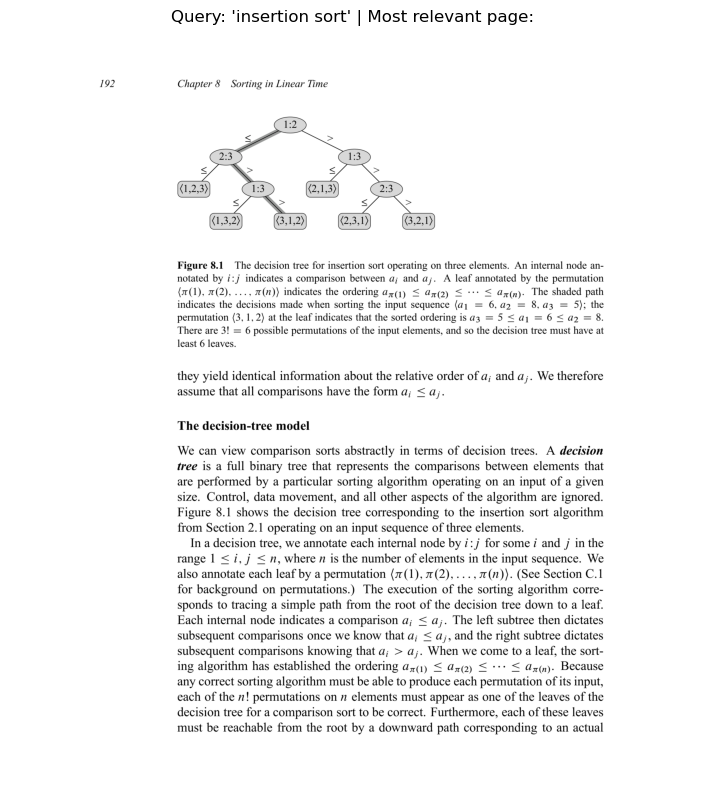

In [64]:
pdf_path = "/Users/adityamishra/Documents/Machine Learning Tutorial/4. RAG/clrs.pdf"
doc = fitz.open(pdf_path)# opening the pdf document
page = doc.load_page(171+41)# 

# Get the image of the page
img = page.get_pixmap(dpi=300)
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()